Found 2355 files belonging to 3 classes.
Found 295 files belonging to 3 classes.
Found 297 files belonging to 3 classes.


Model: "xception_head_only"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)                          ┃ Output Shape                  ┃        Param # ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer_7 (InputLayer)            │ (None, 299, 299, 3)           │              0 │    -    │
├───────────────────────────────────────┼───────────────────────────────┼────────────────┼─────────┤
│ augment (Sequential)                  │ (None, 299, 299, 3)           │              0 │    -    │
├───────────────────────────────────────┼───────────────────────────────┼────────────────┼─────────┤
│ true_divide_2 (TrueDivide)            │ (None, 299, 299, 3)           │              0 │    -    │
├───────────────────────────────────────┼───────────────────────────────┼────────────────┼─────────┤
│ subtract_2 (Subtract)                 │ (None, 299, 299, 3)           │              0 │    -    │
├───────────────────────────────────────┼───────────────────────────────┼────────────────┼─────────┤
│ xception (Functional)                 │ (None, 10, 10, 2048)          │     20,861,480 │    N    │
├───────────────────────────────────────┼───────────────────────────────┼────────────────┼─────────┤
│ global_average_pooling2d_2            │ (None, 2048)                  │              0 │    -    │
│ (GlobalAveragePooling2D)              │                               │                │         │
├───────────────────────────────────────┼───────────────────────────────┼────────────────┼─────────┤
│ dropout_2 (Dropout)                   │ (None, 2048)                  │              0 │    -    │
├───────────────────────────────────────┼───────────────────────────────┼────────────────┼─────────┤
│ dense_2 (Dense)                       │ (None, 3)                     │          6,147 │    Y    │
└───────────────────────────────────────┴───────────────────────────────┴────────────────┴─────────┘

 Total params: 20,867,627 (79.60 MB)

 Trainable params: 6,147 (24.01 KB)

 Non-trainable params: 20,861,480 (79.58 MB)

None

=== Stage 1: Train head only (base frozen) ===
Epoch 1/2
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.6394 - f1: 0.6207 - loss: 0.8465 - precision: 0.6760 - recall: 0.6256
Confusion Matrix:
[[93 11  0]
 [ 9 87  6]
 [ 0 12 77]]
  clear: 0.894
  cloudy: 0.853
  overcast: 0.865
74/74 ━━━━━━━━━━━━━━━━━━━━ 728s 10s/step - accuracy: 0.7550 - f1: 0.7541 - loss: 0.6965 - precision: 0.7765 - recall: 0.7502 - val_accuracy: 0.8712 - val_f1: 0.8730 - val_loss: 0.4691 - val_precision: 0.8768 - val_recall: 0.8708
Epoch 2/2
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8382 - f1: 0.8395 - loss: 0.4676 - precision: 0.8474 - recall: 0.8358
Confusion Matrix:
[[93 11  0]
 [ 8 89  5]
 [ 0 12 77]]
  clear: 0.894
  cloudy: 0.873
  overcast: 0.865
74/74 ━━━━━━━━━━━━━━━━━━━━ 589s 8s/step - accuracy: 0.8539 - f1: 0.8561 - loss: 0.4312 - precision: 0.8606 - recall: 0.8533 - val_accuracy: 0.8780 - val_f1: 0.8799 - val_loss: 0.3645 - val_precision: 0.8848 - val_recall: 0.8773


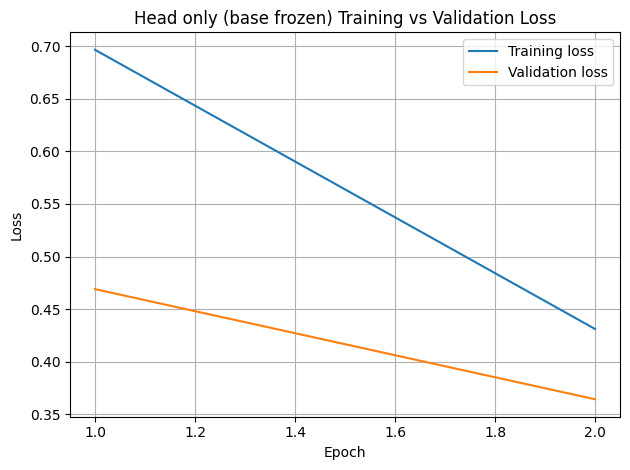

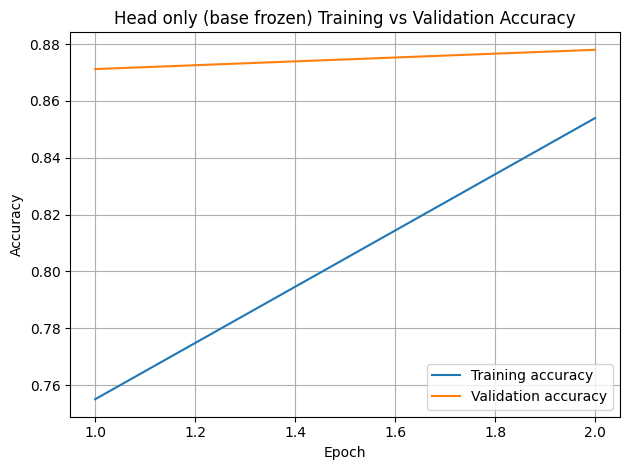

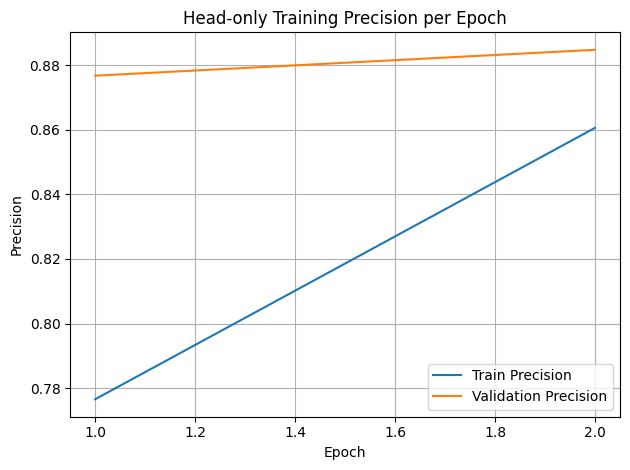

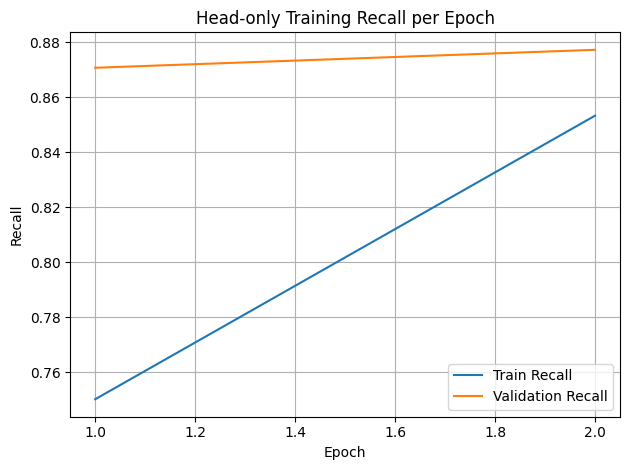

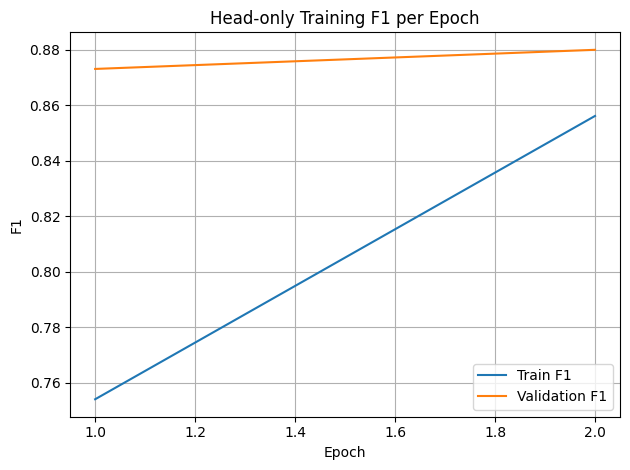

In [4]:
import os
import pathlib
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications.xception import preprocess_input

from sklearn.metrics import classification_report, confusion_matrix
from math import ceil

# --------------------
# CONFIGS
# --------------------
DATA_DIR   = "data/dataset"
CLASS_NAMES = ["clear", "cloudy", "overcast"]

IMG_SIZE   = (299, 299)     # Xception wants 299x299 images
BATCH_SIZE = 32
SEED       = 42

# Training length and learning rates
EPOCHS_HEAD = 20
LR_HEAD     = 3e-4 # learning rate for head training
LR_FT       = 1e-5 # learning rate for fine-tuning (smaller so we don't break pretraining)

# Reproducibility (same result each run, as much as possible)
tf.keras.utils.set_random_seed(SEED)

# --------------------
# 1) LOADING THE DATA
# --------------------
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(DATA_DIR, "train"),
    labels="inferred",
    label_mode="int",
    class_names=CLASS_NAMES,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(DATA_DIR, "val"),
    labels="inferred",
    label_mode="int",
    class_names=CLASS_NAMES,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False,
)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(DATA_DIR, "test"),
    labels="inferred",
    label_mode="int",
    class_names=CLASS_NAMES,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

# --------------------
# 2) BUILD MODEL (Xception base + small head)
# --------------------

from tensorflow.keras.applications import Xception

base = Xception(
    include_top=False,
    weights="imagenet",               # start from pretrained imagenet weights
    input_shape=IMG_SIZE + (3,)
)
base.trainable = False                # freeze all layers

# Creating a new head on top of the Xception base.
inputs = keras.Input(shape=IMG_SIZE + (3,))
x = preprocess_input(x)                     # scale all pixels the way Xception wants
x = base(x)
x = layers.GlobalAveragePooling2D()(x)      # compress HxW features into a single vector
x = layers.Dropout(0.2)(x)                 # drop 20% neurons randomly to avoid overfitting
outputs = layers.Dense(len(CLASS_NAMES), activation="softmax")(x)  # multi-class classification 3 numbers that sum to 1
# This outputs o vector with 3 numbers, one per class [0.80,0.10,0.10] --> 80% probability that it is clear

model = keras.Model(inputs, outputs, name="xception_head_only")

print(model.summary(show_trainable=True))

# ---------------------
# 2b) ADD CUSTOM METRICS (Macro Precision, Macro Recall, Macro F1)
# ----------------------
# These three classes compute macro-averaged precision, recall, and F1
# for multi-class classification. 
#   Each of these metrics maintain a confusion matrix which is updated batch by batch in
#   update_state().
#   In result() true positives, false positives and false
#   negatives per class are derived from this confusion matrix.
#   From these values precision, recall and F1 per class is computed, then
#   averaged over all classes. 
#   The initial template for these metrics was generated with ChatGPT.
#   The code was then simplified and adapted for this use case of multiclass classification 
#   for printing the metrics after each epoch. 

NUM_CLASSES = len(CLASS_NAMES)

class MacroPrecision(tf.keras.metrics.Metric):
    def __init__(self, num_classes, name="precision", **kwargs):
        super().__init__(name=name, **kwargs)
        self.num_classes = num_classes
        self.conf_mat = self.add_weight(
            name="conf_mat",
            shape=(num_classes, num_classes),
            initializer="zeros",
            dtype=self.dtype
        )

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.cast(tf.reshape(y_true, [-1]), tf.int32)
        y_pred = tf.argmax(y_pred, axis=-1)
        y_pred = tf.cast(tf.reshape(y_pred, [-1]), tf.int32)

        cm = tf.math.confusion_matrix(
            y_true, y_pred,
            num_classes=self.num_classes,
            dtype=self.dtype
        )
        self.conf_mat.assign_add(cm)

    def result(self):
        tp = tf.linalg.diag_part(self.conf_mat)
        fp = tf.reduce_sum(self.conf_mat, axis=0) - tp
        precision_per_class = tp / (tp + fp + 1e-7)
        return tf.reduce_mean(precision_per_class)

    def reset_state(self):
        self.conf_mat.assign(tf.zeros_like(self.conf_mat))
        

class MacroRecall(tf.keras.metrics.Metric):
    def __init__(self, num_classes, name="recall", **kwargs):
        super().__init__(name=name, **kwargs)
        self.num_classes = num_classes
        self.conf_mat = self.add_weight(
            name="conf_mat",
            shape=(num_classes, num_classes),
            initializer="zeros",
            dtype=self.dtype
        )

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.cast(tf.reshape(y_true, [-1]), tf.int32)
        y_pred = tf.argmax(y_pred, axis=-1)
        y_pred = tf.cast(tf.reshape(y_pred, [-1]), tf.int32)

        cm = tf.math.confusion_matrix(
            y_true, y_pred,
            num_classes=self.num_classes,
            dtype=self.dtype
        )
        self.conf_mat.assign_add(cm)

    def result(self):
        tp = tf.linalg.diag_part(self.conf_mat)
        fn = tf.reduce_sum(self.conf_mat, axis=1) - tp
        recall_per_class = tp / (tp + fn + 1e-7)
        return tf.reduce_mean(recall_per_class)

    def reset_state(self):
        self.conf_mat.assign(tf.zeros_like(self.conf_mat))


class MacroF1(tf.keras.metrics.Metric):
    def __init__(self, num_classes, name="f1", **kwargs):
        super().__init__(name=name, **kwargs)
        self.num_classes = num_classes
        self.conf_mat = self.add_weight(
            name="conf_mat",
            shape=(num_classes, num_classes),
            initializer="zeros",
            dtype=self.dtype
        )

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.cast(tf.reshape(y_true, [-1]), tf.int32)
        y_pred = tf.argmax(y_pred, axis=-1)
        y_pred = tf.cast(tf.reshape(y_pred, [-1]), tf.int32)

        cm = tf.math.confusion_matrix(
            y_true, y_pred,
            num_classes=self.num_classes,
            dtype=self.dtype
        )
        self.conf_mat.assign_add(cm)

    def result(self):
        tp = tf.linalg.diag_part(self.conf_mat)
        fp = tf.reduce_sum(self.conf_mat, axis=0) - tp
        fn = tf.reduce_sum(self.conf_mat, axis=1) - tp

        precision_per_class = tp / (tp + fp + 1e-7)
        recall_per_class    = tp / (tp + fn + 1e-7)

        f1_per_class = 2 * precision_per_class * recall_per_class / (
            precision_per_class + recall_per_class + 1e-7
        )
        return tf.reduce_mean(f1_per_class)

    def reset_state(self):
        self.conf_mat.assign(tf.zeros_like(self.conf_mat))


class ConfusionMatrixCallback(tf.keras.callbacks.Callback):
    def __init__(self, val_ds, class_names):
        super().__init__()
        self.val_ds = val_ds
        self.class_names = class_names

    def on_epoch_end(self, epoch, logs=None):
        y_true = []
        y_pred = []

        # Loop over validation dataset
        for images, labels in self.val_ds:
            preds = self.model.predict(images, verbose=0)
            preds = np.argmax(preds, axis=1)

            y_true.extend(labels.numpy())
            y_pred.extend(preds)

        # Compute confusion matrix
        cm = confusion_matrix(y_true, y_pred)

        print("\nConfusion Matrix:")
        print(cm)

        # Optional: also print class-by-class accuracy
        class_acc = cm.diagonal() / cm.sum(axis=1)
        for cname, acc in zip(self.class_names, class_acc):
            print(f"  {cname}: {acc:.3f}")


precision_metric = MacroPrecision(NUM_CLASSES)
recall_metric    = MacroRecall(NUM_CLASSES)
f1_metric        = MacroF1(NUM_CLASSES)

# --------------------
# 3) COMPILE & TRAIN (HEAD ONLY)
# --------------------
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LR_HEAD),
    loss="sparse_categorical_crossentropy",  # good for integer labels 0/1/2
   metrics=[
        "accuracy",
        precision_metric,
        recall_metric,
        f1_metric,
    ]
)

callbacks = [
    # Stop early when validation accuracy doesn't improve for 5 epochs (avoids overfitting)
    keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True),
    # Save the best model to file (based on val_accuracy).
    keras.callbacks.ModelCheckpoint("best models/xception_head_best.keras", monitor="val_accuracy", save_best_only=True),
    ConfusionMatrixCallback(val_ds, CLASS_NAMES),
]

print("\n=== Stage 1: Train head only (base frozen) ===")
history_head = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_HEAD,
    callbacks=callbacks,
    verbose=1
)

def plot_loss_and_accuracy(history, title_prefix=""):
    h = history.history
    epochs = range(1, len(h["loss"]) + 1)

    # Loss curve
    plt.figure()
    plt.plot(epochs, h["loss"], label="Training loss")
    plt.plot(epochs, h["val_loss"], label="Validation loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"{title_prefix} Training vs Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    # Accuracy
    plt.figure()
    plt.plot(epochs, h["accuracy"], label="Training accuracy")
    plt.plot(epochs, h["val_accuracy"], label="Validation accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"{title_prefix} Training vs Validation Accuracy")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

plot_loss_and_accuracy(history_head, title_prefix="Head only (base frozen)")

def plot_precision_recall_f1(history, title_prefix=""):
    h = history.history
    epochs = range(1, len(h["loss"]) + 1)

    # ---- Precision ----
    plt.figure()
    plt.plot(epochs, h["precision"], label="Train Precision")
    plt.plot(epochs, h["val_precision"], label="Validation Precision")
    plt.xlabel("Epoch")
    plt.ylabel("Precision")
    plt.title(f"{title_prefix} Precision per Epoch")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    # ---- Recall ----
    plt.figure()
    plt.plot(epochs, h["recall"], label="Train Recall")
    plt.plot(epochs, h["val_recall"], label="Validation Recall")
    plt.xlabel("Epoch")
    plt.ylabel("Recall")
    plt.title(f"{title_prefix} Recall per Epoch")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    # ---- F1 ----
    plt.figure()
    plt.plot(epochs, h["f1"], label="Train F1")
    plt.plot(epochs, h["val_f1"], label="Validation F1")
    plt.xlabel("Epoch")
    plt.ylabel("F1")
    plt.title(f"{title_prefix} F1 per Epoch")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

plot_precision_recall_f1(history_head, title_prefix="Head-only Training")

In [ ]:
# =======================================
# Fine-tune Xception by unfreezing 20, 40 and 80 trainable layers
# =======================================
LR_FT = 1e-5  # small learning rate for fine-tuning
LAYERS_TO_UNFREEZE = [44,88,132] #1/3 , 2/3 and 3/3 of Xception keras layers
histories_ft = {}  # to store histories per setting

for n_layers in LAYERS_TO_UNFREEZE:
    print("\n" + "=" * 60)
    print(f"Fine-tuning with top {n_layers} layers unfrozen")
    print("=" * 60)

    # Load the head-only model fresh for each experiment
    model = keras.models.load_model("xception_head_best.keras", compile=False)
    print("Loaded head-only model.")

    base = model.get_layer("xception")

    # freeze all layers in the base
    for layer in base.layers:
        layer.trainable = False

    # Unfreeze the top N layers
    for layer in base.layers[-n_layers:]:
        layer.trainable = True

    # =======================================
    # Compile & train (fine-tuning)
    # =======================================
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=LR_FT),
        loss="sparse_categorical_crossentropy",
        metrics=[
          "accuracy",
          precision_metric,
          recall_metric,
          f1_metric,
      ]
    )

    callbacks_ft = [
        keras.callbacks.EarlyStopping(
            monitor="val_accuracy",
            patience=3,
            restore_best_weights=True,
            verbose=1
        ),
        keras.callbacks.ModelCheckpoint(
            f"best models/xception_finetuned_top{n_layers}.keras",
            monitor="val_accuracy",
            save_best_only=True,
            verbose=1
        ),
        ConfusionMatrixCallback(
            val_ds,
            CLASS_NAMES
        ),
    ]

    history_ft = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS_HEAD,
        callbacks=callbacks_ft,
        verbose=1
    )

    histories_ft[n_layers] = history_ft

print("\nAll fine-tuning experiments finished.")

# --- Plot Fine-tuned models ---
for n_layers, hist in histories_ft.items():
    plot_loss_and_accuracy(hist, title_prefix=f"Fine-tuning (top {n_layers} layers) –")
    plot_precision_recall_f1(hist, title_prefix=f"Fine-tuning (top {n_layers} layers) –")
